In [1]:
import numpy as np
import pandas as pd
from scipy.special import iv, kv
from matplotlib import pyplot as plt
from PIL import Image
import csv

In [2]:
# Bessel 1st kind modified functions
I0 = lambda x: iv(0, x)
I1 = lambda x: iv(1, x)

# Bessel 2nd kind modified functions
K0 = lambda x: kv(0, x)
K1 = lambda x: kv(1, x)

In [3]:
def load_constants():
    return Image.open('constants-a.png')

In [4]:
M = 10
m = 1.5
r1 = 0.5
phi = 0.2
q0, q1 = 2, 4
omega = 10
pi = np.math.pi
eps = r1

def J(M=M, m=m):
    return 2 * pow(M, 2) / (1 + pow(m, 2))

def A(M=M, m=m):
    return np.sqrt(J(M=M, m=m))

@np.vectorize
def r2(z=0.5, phi=phi):
    """outer cylinder radius equation"""
    return 1 + phi * np.math.cos(2 * pi * z)

# @np.vectorize
# def q(t, q0=q0, q1=q1, omega=omega):
#     return q0 + q1 * np.math.sin(omega * t)

@np.vectorize
def q(t, q0=q0, q1=q1, omega=omega, eps=eps, phi=phi):
    return q0 + q1 * np.math.sin(omega * t) - (1 - pow(eps, 2) + pow(phi, 2) / 2)

In [5]:
def results_path(name):
    import os
    base = './results/newtonian'
    return os.path.abspath(os.path.join(base, name))

def write_results(results, filename):
    assert isinstance(results, dict)
    fieldnames = list(results.keys())
    pd.DataFrame.from_dict(data=results).to_csv(results_path(filename), header=True)

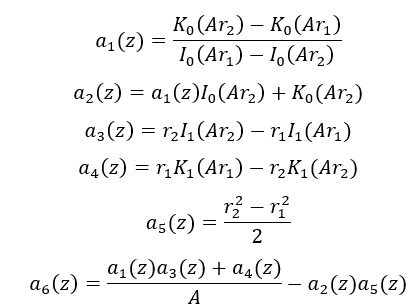

In [6]:
load_constants()

In [12]:
@np.vectorize
def a1(z=0.5, phi=phi, M=M, m=m):
    r2z = r2(z, phi=phi)
    part_1 = K0(A(M=M, m=m) * r2z) - K0(A(M=M, m=m) * r1)
    part_2 = I0(A(M=M, m=m) * r1) - I0(A(M=M, m=m) * r2z)
    return part_1 / part_2

@np.vectorize
def a2(z=0.5, phi=phi, M=M, m=m):
    r2z = r2(z, phi=phi)
    return a1(z, M=M, m=m) * I0(A(M=M, m=m) * r2z) + K0(A(M=M, m=m) * r2z)

@np.vectorize
def a3(z=0.5, phi=phi, M=M, m=m):
    r2z = r2(z, phi=phi)
    return r2z * I1(A(M=M, m=m) * r2z) - r1 * I1(A(M=M, m=m) * r1)

@np.vectorize
def a4(z=0.5, phi=phi, M=M, m=m):
    r2z = r2(z, phi=phi)
    return r1 * K1(A(M=M, m=m) * r1) - r2z * K1(A(M=M, m=m) * r2z)

@np.vectorize
def a5(z=0.5, phi=phi, M=M, m=m):
    r2z = r2(z, phi=phi)
    return (pow(r2z, 2) - pow(r1, 2)) / 2

@np.vectorize
def a6(z=0.5, phi=phi, M=M, m=m):
    part_1 = a1(z, phi=phi, M=M, m=m) * a3(z, phi=phi, M=M, m=m) + a4(z, phi=phi, M=M, m=m)
    part_2 = a5(z, phi=phi, M=M, m=m)
#     return part_1 * a2(z, phi=phi, M=M, m=m) / A(M=M, m=m) - part_2
    return part_1 / A(M=M, m=m) - a2(z, phi=phi, M=M, m=m) * part_2

In [13]:
@np.vectorize
def c2(z=0.5, t=1, phi=phi, M=M, m=m, q0=q0, q1=q1, omega=omega):
    part_1 = 2 * dpdz(z=z, t=t, phi=phi, M=M, m=m, q0=q0, q1=q1, omega=omega)
    part_2 = a2(z, phi=phi, M=M, m=m) * J(M=M, m=m)
    return part_1 / part_2

@np.vectorize
def c1(z=0.5, t=1, phi=phi, M=M, m=m, q0=q0, q1=q1):
    return a1(z, phi=phi, M=M, m=m) * c2(z=z, t=t, phi=phi, M=M, m=m, q0=q0, q1=q1)

In [14]:
@np.vectorize
def dpdz(z=0.5, t=1, phi=phi, M=M, m=m, omega=omega, q0=q0, q1=q1, q_v=None):
#     return 1
    if q_v is None:
        q_v = q(t, q0=q0, q1=q1, omega=omega)
        
    part_1 = a2(z=z, phi=phi, M=M, m=m) * J(M=M, m=m) / (2 * a6(z=z, phi=phi, M=M, m=m))
    part_2 = (q_v / (2 * pi)) + 2 * a5(z=z, phi=phi, M=M, m=m) / J(M=M, m=m)
    return part_1 * part_2

In [31]:
nz = 5
nt = 300
zs = np.linspace(0, 1, nz)
ts = np.linspace(0, 2, nt)
dps = np.zeros((nz, nt))

for (i, ti) in enumerate(ts):
    dps[:,i] = dpdz(z=zs, t=ti, q0=0.8, q1=0.8)

In [32]:
dfdp1 = pd.DataFrame(dps).transpose()
# dfdp1.to_csv(results_path('small_beta_analytical_pressure_gradient_time_evolution.csv'))
dfdp1.head(2)

0         1          2         3         4
0 -1.949317 -2.724291  -5.878661 -2.724291 -1.949317
1 -2.637323 -4.091132 -10.380867 -4.091132 -2.637323

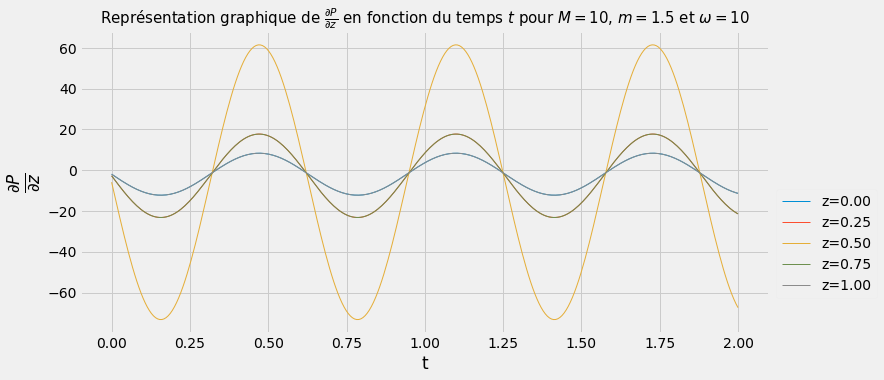

In [33]:
with plt.style.context('fivethirtyeight'):
    for i in np.arange(0, nz):
        z = zs[i]
        plt.plot(ts, dps[i, :], label=f'z={z:.2f}', linewidth=1)
    plt.legend(framealpha=0.1, bbox_to_anchor=(1, 0.5))
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    frac = r'\frac{\partial P}{\partial z}'
    plt.xlabel('t')
    plt.ylabel(f'${frac}$', fontsize=24)
    sp = r'\hspace{0.25}'
    t = fr'Représentation graphique de ${frac}$ en fonction du temps $t$ pour $M=10$, $m=1.5$ et $\omega=10$'
    plt.title(t, fontsize=15)
    plt.tight_layout()
#     plt.savefig('figs/pressure-gradient-newtonian-beta-small.png', transparent=True)

In [34]:
nz2 = 100
nt2 = 5
zs2 = np.linspace(0, 1, nz2)
ts2 = np.linspace(0, 0.5, 2*nt2)
dps2 = np.zeros((nz2, 2*nt2))

for (i, t) in enumerate(ts2):
    dps2[:, i] = dpdz(z=zs2, t=t, omega=10, q0=0.8, q1=0.8)

dfdp2 = pd.DataFrame(dps2).transpose()
# dfdp2.to_csv(results_path('small_beta_analytical_pressure_gradient_with_z.csv'))
dfdp2.head(2)

0         1         2         3         4         5         6   \
0 -1.949317 -1.950235 -1.952994 -1.957611 -1.964115 -1.972549 -1.982965   
1 -7.378189 -7.385201 -7.406287 -7.441590 -7.491354 -7.555925 -7.635752   

         7         8         9   ...        90        91        92        93  \
0 -1.995431 -2.010026 -2.026845  ... -2.026845 -2.010026 -1.995431 -1.982965   
1 -7.731394 -7.843525 -7.972941  ... -7.972941 -7.843525 -7.731394 -7.635752   

         94        95        96        97        98        99  
0 -1.972549 -1.964115 -1.957611 -1.952994 -1.950235 -1.949317  
1 -7.555925 -7.491354 -7.441590 -7.406287 -7.385201 -7.378189  

[2 rows x 100 columns]

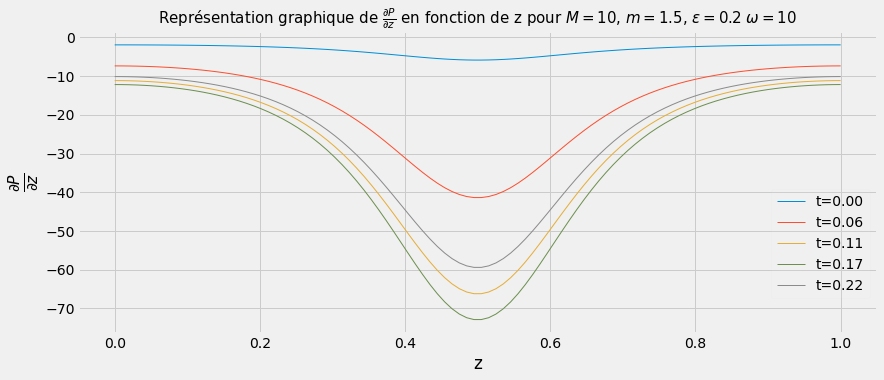

In [35]:
with plt.style.context('fivethirtyeight'):
    for i in np.arange(0, nt2):
        t = ts2[i]
        plt.plot(zs2, dps2[:, i], label=f't={t:.2f}', linewidth=1)
    plt.legend(framealpha=0.1, bbox_to_anchor=(1, 0.5))
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    plt.tight_layout()
    frac = r'$\frac{\partial{P}}{\partial{z}}$'
    plt.xlabel('z')
    plt.ylabel(frac, fontsize=22)
    plt.title(fr'Représentation graphique de {frac} en fonction de z pour $M=10$, $m=1.5$, $\epsilon=0.2$ $\omega=10$', fontsize=15)
    plt.tight_layout()
#     plt.savefig('figs/pressure-gradient-newtonian-beta-small-z.png', transparent=True)

In [36]:
@np.vectorize
def w(r, z=0.5, t=1, phi=phi, M=M, m=m, q0=q0, q1=q1, omega=omega):
    part_1 = c1(z, t, phi=phi, M=M, m=m, q0=q0, q1=q1) * I0(A(M=M, m=m) * r)
    part_2 = c2(z, t, phi=phi, M=M, m=m, q0=q0, q1=q1) * K0(A(M=M, m=m) * r)
    part_3 = 2 * dpdz(z, t, phi=phi, M=M, m=m, q0=q0, q1=q1, omega=omega) / J(M=M, m=m)
    return part_1 + part_2 - part_3 - 1

In [52]:
nr = 50
nt = 15
rs = np.linspace(r1, r2(), nr)
ts = np.linspace(0, 10, nt)
ws = np.zeros((50, 50))

for (i, ti) in enumerate(ts):
    ws[:, i] = w(r=rs, t=ti, q0=0.8, q1=0.8)

In [113]:
df_1 = pd.DataFrame(ws).transpose()
df_1.to_csv('small_beta_analytical_axial_velocity.csv')
df_1.head(2)

0         1         2         3         4         5         6         7   \
0 -1.0 -0.992053 -0.984621 -0.977681 -0.971209 -0.965184 -0.959587 -0.954399   
1 -1.0 -0.923064 -0.851119 -0.783929 -0.721275 -0.662952 -0.608767 -0.558542   

         8         9   ...        40        41        42        43        44  \
0 -0.949603 -0.945183  ... -0.949518 -0.953846 -0.958473 -0.963406 -0.968654   
1 -0.512112 -0.469321  ... -0.511282 -0.553188 -0.597977 -0.645731 -0.696541   

         45        46        47        48   49  
0 -0.974228 -0.980138 -0.986395 -0.993011 -1.0  
1 -0.750500 -0.807713 -0.868288 -0.932342 -1.0  

[2 rows x 50 columns]

In [54]:
ws[:, 1]

array([-1.        , -0.92306434, -0.85111911, -0.78392932, -0.72127524,
       -0.66295164, -0.60876692, -0.55854248, -0.51211199, -0.46932079,
       -0.43002533, -0.39409259, -0.36139962, -0.33183304, -0.30528865,
       -0.28167102, -0.26089311, -0.24287597, -0.2275484 , -0.21484666,
       -0.20471425, -0.19710165, -0.1919661 , -0.18927145, -0.18898792,
       -0.19109204, -0.19556641, -0.20239971, -0.21158648, -0.22312714,
       -0.23702786, -0.25330056, -0.27196286, -0.29303804, -0.31655508,
       -0.34254867, -0.37105921, -0.40213287, -0.43582166, -0.4721835 ,
       -0.51128229, -0.55318801, -0.59797688, -0.64573145, -0.69654073,
       -0.75050042, -0.80771303, -0.86828808, -0.93234234, -1.        ])

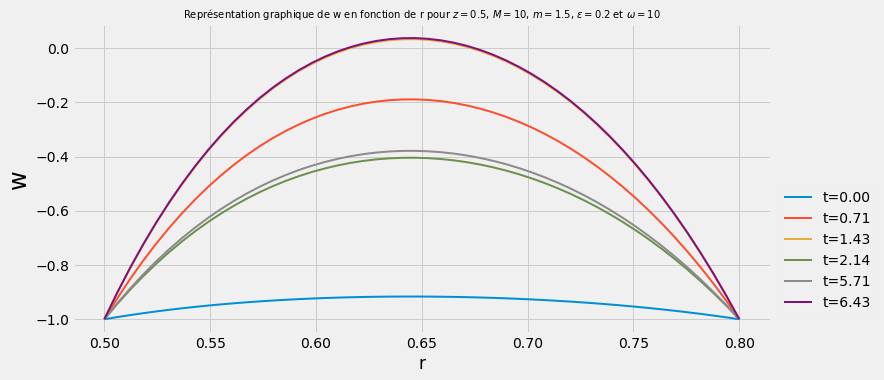

In [56]:
with plt.style.context('fivethirtyeight'):
    for i in range(nt - 5):
        if np.any(ws[:, i] < -1):
            continue
        t = ts[i]
        plt.plot(rs, ws[:, i], label=f't={t:.2f}', linewidth=2)

    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    plt.legend(framealpha=0.1, bbox_to_anchor=(1, 0.5))
    plt.xlabel('r')
    plt.ylabel('w', fontsize=24)
    plt.title(r'Représentation graphique de w en fonction de r pour $z=0.5$, $M=10$, $m=1.5$, $\epsilon=0.2$ et $\omega=10$', fontsize=10)
    plt.tight_layout()
#     plt.savefig('figs/axial-velocity-newtonian-beta-small.png', transparent=True)

In [114]:
import csv

In [133]:
df_num = pd.read_csv('results/newtonian/small_beta_numerical_axial_velocity.csv', header=None)
df_num = df_num.loc[1:, 1:]

In [134]:
df_num.head(2)

1         2         3         4         5         6         7         8     \
1  -1.0 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   
2  -1.0 -0.997395 -0.994163 -0.992279 -0.990887 -0.989556 -0.988349 -0.987262   

       9         10    ...      1668      1669      1670      1671      1672  \
1 -1.000000 -1.000000  ... -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   
2 -0.986178 -0.985079  ... -0.882815 -0.882996 -0.883174 -0.883375 -0.883591   

       1673      1674      1675      1676      1677  
1 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000  
2 -0.883763 -0.883933 -0.884126 -0.884313 -0.884497  

[2 rows x 1677 columns]

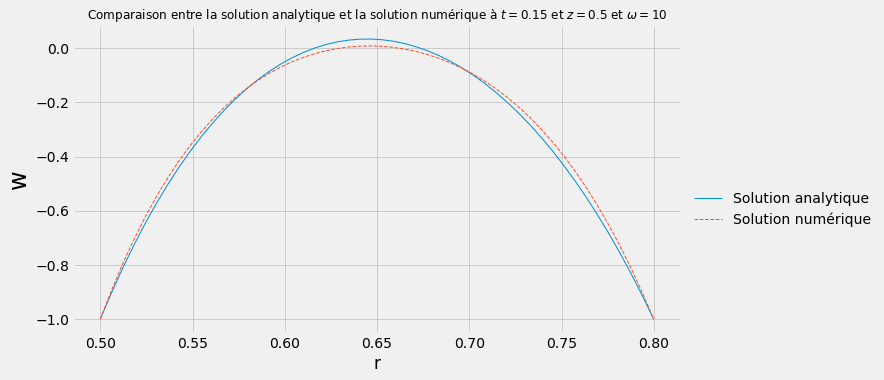

In [142]:
with plt.style.context('fivethirtyeight'):
    plt.plot(rs, ws[:, 2], label='Solution analytique', linewidth=1)
    plt.plot(rs, df_num.loc[:, 230], label='Solution numérique', linestyle='dashed', linewidth=1)

    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    plt.legend(framealpha=0.1, bbox_to_anchor=(1, 0.5))
    plt.xlabel('r')
    plt.ylabel('w', fontsize=24)
    plt.title(r'Comparaison entre la solution analytique et la solution numérique à $t=0.15$ et $z=0.5$ et $\omega=10$', fontsize=12)
    plt.tight_layout()
    plt.savefig('figs/validation-newtonian-2.png', transparent=True)

In [110]:
# axial velocity profile with different values of Hartmann number
nr = 50
rs = np.linspace(r1, r2(), nr)
ws_1 = w(rs, t=2, M=5)
ws_2 = w(rs, t=2, M=10)
ws_3 = w(rs, t=2, M=15)
ws_4 = w(rs, t=2, M=20)

In [111]:
ws_0 = w(rs, t=2, M=1)

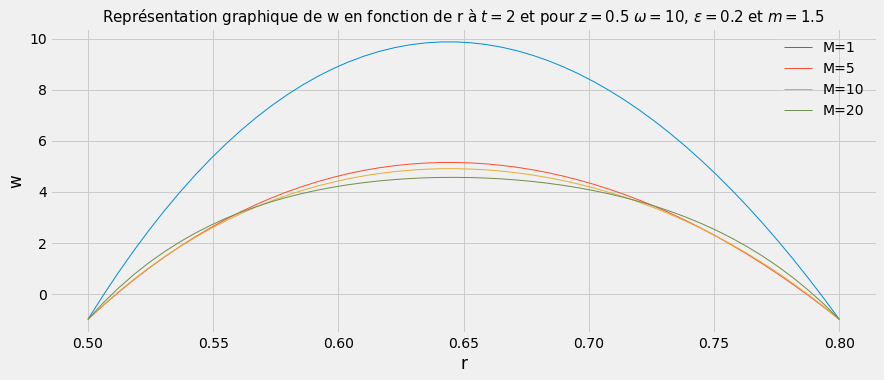

In [112]:
with plt.style.context('fivethirtyeight'):
    plt.plot(rs, ws_0, linewidth=1, label='M=1')
    plt.plot(rs, ws_1, linewidth=1, label='M=5')
    plt.plot(rs, ws_2, linewidth=1, label='M=10')
#     plt.plot(rs, ws_3, linewidth=1, label='M=15')
    plt.plot(rs, ws_4, linewidth=1, label='M=20')
    
    fig = plt.gcf()
    fig.set_size_inches((12.5, 5.5))
    plt.legend(framealpha=0.1)
    
    plt.xlabel('r')
    plt.ylabel('w')
    plt.title(r'Représentation graphique de w en fonction de r à $t=2$ et pour $z=0.5$ $\omega=10$, $\epsilon=0.2$ et $m=1.5$', fontsize=15)
    
    plt.tight_layout()
#     plt.savefig('figs/axial-velocity-newtonian-beta-small-Hartmann.png', transparent=True)

In [48]:
# axial velocity profile with different values of Hartmann number
nr = 50
rs = np.linspace(r1, r2(), nr)
ws_5 = w(rs, t=2, m=1)
ws_6 = w(rs, t=2, m=1.5)
ws_7 = w(rs, t=2, m=2)
ws_8 = w(rs, t=2, m=0)

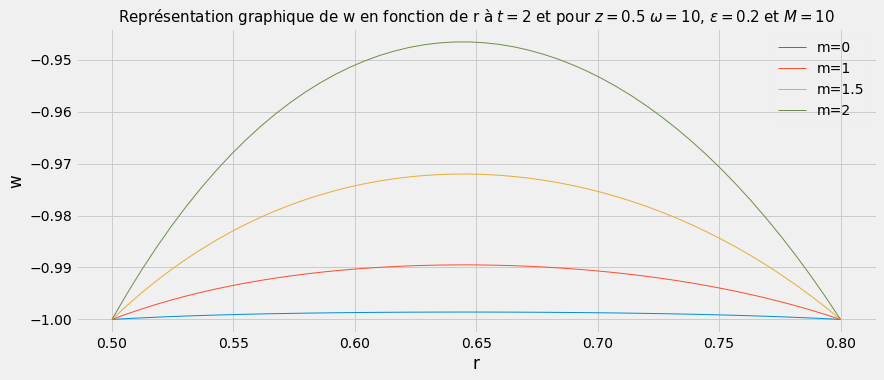

In [51]:
with plt.style.context('fivethirtyeight'):
    plt.plot(rs, ws_8, linewidth=1, label='m=0')
    plt.plot(rs, ws_5, linewidth=1, label='m=1')
    plt.plot(rs, ws_6, linewidth=1, label='m=1.5')
    plt.plot(rs, ws_7, linewidth=1, label='m=2')
    
    fig = plt.gcf()
    fig.set_size_inches((12.5, 5.5))
    plt.legend(framealpha=0.1)
    
    plt.xlabel('r')
    plt.ylabel('w')
    plt.title(r'Représentation graphique de w en fonction de r à $t=2$ et pour $z=0.5$ $\omega=10$, $\epsilon=0.2$ et $M=10$', fontsize=15)
    
    plt.tight_layout()
    plt.savefig('figs/axial-velocity-newtonian-beta-small-Hall.png', transparent=True)

In [65]:
from scipy.integrate import simps

In [66]:
@np.vectorize
def y(q=1, z=0.5, phi=phi, M=M, m=m):
    part_1 = q/(2 * pi)
    part_2 = 2 * a5(z=z, phi=phi, M=M, m=m) / J(M=M, m=m)
    part_3 = a2(z=z, phi=phi, M=M, m=m) * J(M=M, m=m) / (2 * a6(z=z, phi=phi, M=M, m=m))
    return (part_1 + part_2) * part_3

nq = 20
qs = np.linspace(-1, 1, nq)
zs = np.linspace(0, 1, 100)

In [67]:
# occlusion=0.1
delta_p_1 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, phi=0.1)
    delta_p_1[i] = simps(ys, zs)

In [68]:
# occlusion=0.2
delta_p_2 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, phi=0.2)
    delta_p_2[i] = simps(ys, zs)

In [69]:
# occlusion=0.3
delta_p_3 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, phi=0.3)
    delta_p_3[i] = simps(ys, zs)

In [70]:
# occlusion=0.4
delta_p_4 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, phi=0.4)
    delta_p_4[i] = simps(ys, zs)

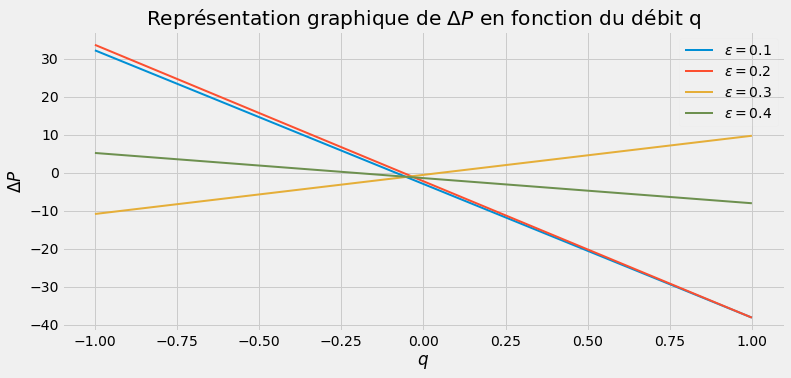

In [71]:
with plt.style.context('fivethirtyeight'):
    plt.plot(qs, delta_p_1, linewidth=2, label=r'$\epsilon=0.1$')
    plt.plot(qs, delta_p_2, linewidth=2, label=r'$\epsilon=0.2$')
    plt.plot(qs, delta_p_3, linewidth=2, label=r'$\epsilon=0.3$')
    plt.plot(qs, delta_p_4, linewidth=2, label=r'$\epsilon=0.4$')
#     plt.plot(qs, delta_p_8, linewidth=2, label=r'$\epsilon=0.8$')

    plt.xlabel('$q$')
    plt.ylabel('$\Delta P$')
    plt.tight_layout()
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    plt.legend(framealpha=0.1)
    plt.title('Représentation graphique de $\Delta P$ en fonction du débit q')
#     plt.savefig('figs/newtonian-pressure-drop-beta-small.png', transparent=True, dpi=100)

In [73]:
delta_p_M1 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, M=1)
    delta_p_M1[i] = simps(ys, zs)

In [82]:
delta_p_M2 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, M=2)
    delta_p_M2[i] = simps(ys, zs)

In [83]:
delta_p_M3 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, M=3)
    delta_p_M3[i] = simps(ys, zs)

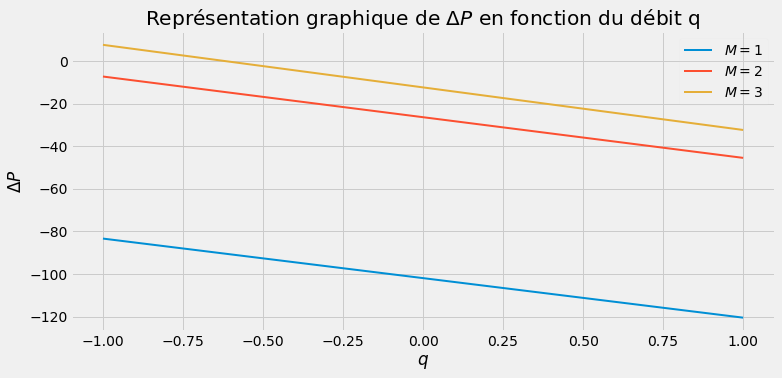

In [84]:
with plt.style.context('fivethirtyeight'):
    plt.plot(qs, delta_p_M1, linewidth=2, label=r'$M=1$')
    plt.plot(qs, delta_p_M2, linewidth=2, label=r'$M=2$')
    plt.plot(qs, delta_p_M3, linewidth=2, label=r'$M=3$')
#     plt.plot(qs, delta_p_M5, linewidth=2, label=r'$M=5$')
#     plt.plot(qs, delta_p_M20, linewidth=2, label=r'$M=20$')

    plt.xlabel('$q$')
    plt.ylabel('$\Delta P$')
    plt.tight_layout()
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    plt.legend(framealpha=0.1)
    plt.title('Représentation graphique de $\Delta P$ en fonction du débit q')
#     plt.savefig('figs/newtonian-pressure-drop-beta-small-Hartmann.png', transparent=True, dpi=100)


In [89]:
M=0 #(No magnetic field)
def a7(z=0.5, phi=phi):
    _r2 = r2(z=z, phi=phi)
    part_1 = np.math.pow(_r2, 2) * np.log(_r2)
    part_2 = np.math.pow(r1, 2) * np.log(r1)
    return (part_2 - part_1) / 2

@np.vectorize
def q(t, q0=q0, q1=q1, omega=omega, eps=eps, phi=phi):
    return q0 + q1 * np.math.sin(omega * t) - (1 - pow(eps, 2) + pow(phi, 2) / 2)

@np.vectorize
def f(z=0.5, t=1, phi=phi):
    _r2 = r2(z=z, phi=phi)
    part_1 = (np.math.pow(_r2, 4) - np.math.pow(r1, 4)) / 8
    part_2 = a5(z=z, phi=phi, M=0, m=0) * np.math.pow(r1, 2) / 2
    part_3 = a5(z=z, phi=phi, M=0, m=0) * np.math.pow(np.log(_r2/ r1), -1)
    part_4 = a7(z=z, phi=phi) - a5(z=z, phi=phi, M=0, m=0) * (0.5 - np.log(_r2))
    return part_1 - part_2 - part_3 * part_4

@np.vectorize
def dpdz_(z=0.5, t=1, phi=phi, omega=omega, q0=q0, q1=q1, q_v=None):
    if not q_v:
        q_v = q(t, omega=omega, q0=q0, q1=q1)
    part_1 = q_v / (2 * pi)
    part_2 = a5(z=z, phi=phi, M=0, m=0)
    return -(part_1 + part_2) * np.math.pow(f(z=z, t=t, phi=phi), -1)

In [90]:
nz = 10
nt = 100
zs = np.linspace(0, 1, nz)
ts = np.linspace(0, 2, nt)
dps_ = np.zeros((nz, nt))

for (i, ti) in enumerate(ts):
    dps_[:,i] = dpdz_(z=zs, t=ti)

In [91]:
dfp_ = pd.DataFrame(dps_).transpose()
dfp_.head(2)

0         1         2         3         4         5         6  \
0 -1.743379 -1.897647 -2.412483 -3.376802 -4.461907 -4.461907 -3.376802   
1 -2.024999 -2.227126 -2.920926 -4.283440 -5.885067 -5.885067 -4.283440   

          7         8         9  
0 -2.412483 -1.897647 -1.743379  
1 -2.920926 -2.227126 -2.024999

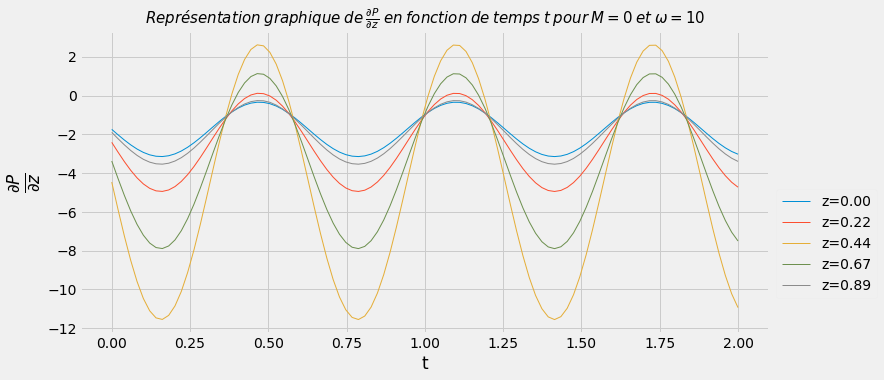

In [92]:
with plt.style.context('fivethirtyeight'):
    for i in np.arange(0, nz, 2):
        z = zs[i]
        plt.plot(ts, dps_[i, :], label=f'z={z:.2f}', linewidth=1)
    plt.legend(framealpha=0.1, bbox_to_anchor=(1, 0.5))
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    frac = r'\frac{\partial P}{\partial z}'
    plt.xlabel('t')
    plt.ylabel(f'${frac}$', fontsize=24)
    sp = r'\hspace{0.25}'
    t = fr'$Représentation{sp}graphique{sp}de{sp}{frac}{sp}en{sp}fonction{sp}de{sp}temps{sp}t{sp}pour{sp}M=0{sp}et{sp}\omega=10$'
    plt.title(t, fontsize=15)
    plt.tight_layout()
#     plt.savefig('figs/pressure-gradient-newtonian-beta-small-no-hartmann.png', transparent=True)

In [93]:
@np.vectorize
def c1_(z=0.5, t=1, phi=phi, q0=q0, q1=q1, omega=omega, q_v=None):
    part_1 = -a5(z, phi=phi) 
    part_2 = dpdz_(z=z, t=t, phi=phi, omega=omega, q0=q0, q1=q1, q_v=q_v)
    part_3 = np.log(r2(z=z, phi=phi) / r1)
    return  part_1 * part_2 * np.math.pow(part_3, -1)

@np.vectorize
def c2_(z=0.5, t=1, phi=phi, q0=q0, q1=q1, omega=omega, q_v=None):
    part_1 = np.math.pow(r1, 2) * dpdz_(z=z, t=t, phi=phi, omega=omega, q0=q0, q1=q1, q_v=q_v) / 2
    part_2 = c1_(z=z, t=t, phi=phi, q0=q0, q1=q1, omega=omega, q_v=q_v) * np.log(r1)
    return -1 - part_1 - part_2

@np.vectorize
def w_(r, z=0.5, t=1, phi=phi, q0=q0, q1=q1, omega=omega, q_v=None):
    part_1 = dpdz_(z=z, t=t, phi=phi, omega=omega, q0=q0, q1=q1, q_v=q_v) * np.math.pow(r, 2) / 2
    part_2 = c1_(z=z, t=t, phi=phi, q0=q0, q1=q1, omega=omega, q_v=q_v) * np.log(r)
    part_3 = c2_(z=z, t=t, phi=phi, q0=q0, q1=q1, omega=omega, q_v=q_v)
    return part_1 + part_2 + part_3

In [103]:
nr = 50
nt = 10
rs = np.linspace(r1, r2(), nr)
ts = np.linspace(0, 10, nt)
ws_ = np.zeros((50, 50))

for (i, ti) in enumerate(ts):
    ws_[:, i] = w_(r=rs, t=ti, q0=0.8, q1=0.8)

In [104]:
dfw_ = pd.DataFrame(ws_).transpose()
dfw_.head(2)

0         1         2         3         4         5         6         7   \
0 -1.0 -0.995307 -0.990848 -0.986620 -0.982619 -0.978842 -0.975285 -0.971947   
1 -1.0 -0.998278 -0.996642 -0.995091 -0.993623 -0.992237 -0.990932 -0.989707   

         8         9   ...        40        41        42        43        44  \
0 -0.968824 -0.965913  ... -0.969130 -0.971950 -0.974924 -0.978053 -0.981334   
1 -0.988561 -0.987493  ... -0.988674 -0.989708 -0.990799 -0.991947 -0.993151   

         45        46        47        48   49  
0 -0.984767 -0.988351 -0.992085 -0.995969 -1.0  
1 -0.994411 -0.995726 -0.997096 -0.998521 -1.0  

[2 rows x 50 columns]

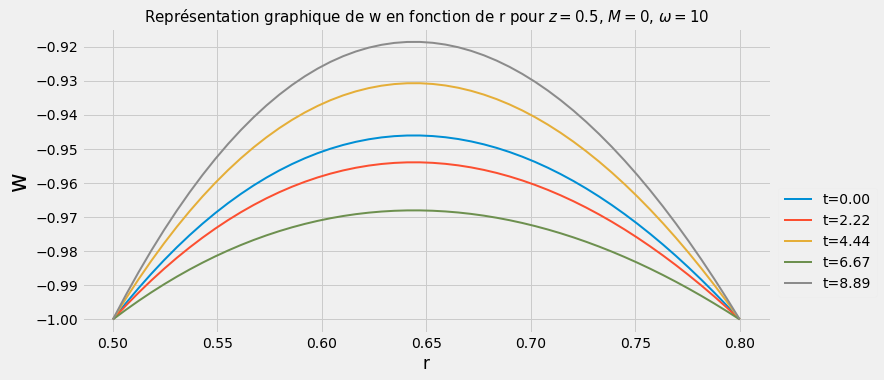

In [105]:
with plt.style.context('fivethirtyeight'):
    for i in range(5):
        if np.any(ws_[:, i * 2] < -1):
            continue
        t = ts[i * 2]
        plt.plot(rs, ws_[:, i * 2], label=f't={t:.2f}', linewidth=2)

    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    plt.legend(framealpha=0.1, bbox_to_anchor=(1, 0.5))
    plt.xlabel('r')
    plt.ylabel('w', fontsize=24)
    
    t = r'Représentation graphique de w en fonction de r pour $z=0.5$, $M=0$, $\omega=10$'
    plt.title(t, fontsize=15)
    plt.tight_layout()
#     plt.savefig('figs/axial-velocity-newtonian-beta-small-no-hartmann.png', transparent=True)

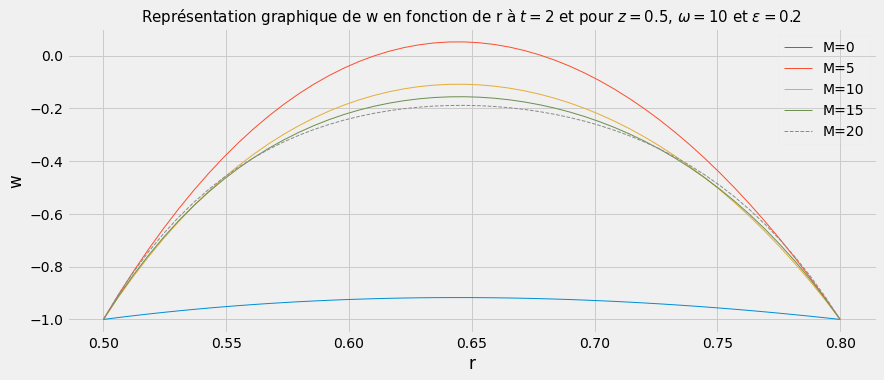

In [106]:
with plt.style.context('fivethirtyeight'):
    plt.plot(rs, w_(r=rs, t=0.1, q0=0.8, q1=0.8), linewidth=1, label='M=0')
    plt.plot(rs, ws_1, linewidth=1, label='M=5')
    plt.plot(rs, ws_2, linewidth=1, label='M=10')
    plt.plot(rs, ws_3, linewidth=1, label='M=15')
    plt.plot(rs, ws_4, linewidth=1, label='M=20', linestyle='dashed')
    plt.legend(framealpha=0.1)
    
    fig = plt.gcf()
    fig.set_size_inches((12.5, 5.5))
    
    plt.xlabel('r')
    plt.ylabel('w')
    plt.title('Représentation graphique de w en fonction de r à $t=2$ et pour $z=0.5$, $\omega=10$ et $\epsilon=0.2$', fontsize=15)
    
    plt.tight_layout()
#     plt.savefig('figs/axial-velocity-newtonian-beta-small-Hartmann-0.png', transparent=True)